In [1]:
import os
import json
#!pip install spotipy
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import spotipy.util as util
import pandas as pd
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt

import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials

In [2]:
cid ='d8762235995b4ddcbc0df90739df9a63' # Client ID; copy this from your app created on beta.developer.spotify.com
secret = '887a4eccdbde4195bfc0f7f4c472fe70' # Client Secret; copy this from your app
username = '12155311349' # Your Spotify username

#for avaliable scopes see https://developer.spotify.com/web-api/using-scopes/
scope = 'user-library-read playlist-modify-public playlist-read-private'
redirect_uri='https://localhost:8080/callback/'
client_credentials_manager = SpotifyClientCredentials(client_id=cid, client_secret=secret) 
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)

token = util.prompt_for_user_token(username,scope,client_id=cid,client_secret=secret,redirect_uri="https://localhost:8080/callback/")
if token:
    sp = spotipy.Spotify(auth=token)
else:
    print("Can't get token for", username)

In [3]:
# song_name = input("Search a song for recommendations: ")

# User Playlist


In [21]:
#Creating function and having user give PlaylistID, and genre (0 = counrty, 1 = rock...)
def input_playlist(playlistID, genre): 

    playlist = sp.user_playlist(username, playlistID);

    tracks = playlist["tracks"];
    songs = tracks["items"];
    total_tracks = tracks["total"]
    
    # Iterate over all tracks in the playlist using offset to get beyond the first 100 tracks
    for i in range(100, total_tracks, 100):
        tracks = sp.user_playlist_tracks(username, playlistID, offset=i)
        songs += tracks["items"]
        
    #Putting Track ID, Track Name, Album, and artist name in matrix's

    track_ids = [] 
    track_names = []
    album = []
    artist =[]

    #Getting Track Data
    for i in range(0, len(songs)):
        if songs[i]['track']['id'] != None: # Removes the local tracks in your playlist if there is any
            track_ids.append(songs[i]['track']['id'])
            track_names.append(songs[i]['track']['name'])
            album.append(songs[i]['track']['album']['name'])
            artist.append(songs[i]['track']['artists'][0]['name'])

    features = []
    for i in range(0,len(songs)):
        audio_features = sp.audio_features(track_ids[i])
        for track in audio_features:

          if track is None:
            print(track)
            features.append({'danceability': 0, 'energy': 0, 'key': 0, 'loudness': 0, 'mode': 0, 'speechiness': 0, 'acousticness': 0, 'instrumentalness': 0, 'liveness': 0, 'valence': 0, 'tempo': 0, 'type': 'audio_features', 'id': '00000', 'uri': 'spotify:track:0', 'track_href': 'https://api.spotify.com/', 'analysis_url': 'https://api.spotify.com/', 'duration_ms': 0, 'time_signature': 0})
          else:
            features.append(track)

    #Creating our DataFrames
    df = pd.DataFrame(features, index = track_names) 

    #Adding a new column
    df['genre'] = genre #Country
    df['Song Title'] = track_names
    df['Artist'] = artist

    # Scale between 0 and 1
    df["key"] = (df["key"] / df["key"].max())
    df["tempo"] = (df["tempo"] / df["tempo"].max())
    df["loudness"] = (df["loudness"] / df["loudness"].min())
    
    #calculate the IQR for instrumentalness and acousticness
    Q1 = df["instrumentalness"].quantile(0.25)
    Q3 = df["instrumentalness"].quantile(0.75)
    IQR = Q3 - Q1
    
    Q12 = df["acousticness"].quantile(0.25)
    Q32 = df["acousticness"].quantile(0.75)
    IQR2 = Q32 - Q12
    
    #Remove rows with outliers
    df = df[~((df["instrumentalness"] < (df["instrumentalness"].quantile(0.25) - 1.5 * IQR)) | (df["instrumentalness"] > (df["instrumentalness"].quantile(0.75) + 1.5 * IQR)))]
    df = df[~((df["acousticness"] < (df["acousticness"].quantile(0.25) - 1.5 * IQR2)) | (df["acousticness"] > (df["acousticness"].quantile(0.75) + 1.5 * IQR2)))]
    
#     Q1 = df.quantile(0.25)
#     Q3 = df.quantile(0.75)
#     IQR = Q3 - Q1
#     df = df[~((df.sub(Q1, axis=1).div(IQR, axis=1)).lt(-1.5) | (df.sub(Q1, axis=1).div(IQR, axis=1)).gt(1.5)).any(axis=1)]
    return df

In [26]:
userPlaylistID= 'https://open.spotify.com/playlist/4P3NZ1qRZn9eDLpy59YOdj?si=da0a03bf133e469f' #Retro Playlist
playlist = sp.user_playlist(username, userPlaylistID);

In [27]:
# Get the audio features for each track in the playlist
audio_features = {}
for track in playlist['tracks']['items']:
    audio_features[track['track']['id']] = sp.audio_features(track['track']['id'])[0]

# Create a dataframe with the track information
columns = ['song name', 'artist', 'popularity', 'release date', 'iD', 'danceability', 'energy','loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo']
data = []
for i, track in enumerate(playlist['tracks']['items']):
    name = track['track']['name']
    artist = track['track']['artists'][0]['name']
    popularity = track['track']['popularity']
    year = track['track']['album']['release_date'][:4]
    track_id = track['track']['id']
    audio_features = sp.audio_features([track_id])[0]
    danceability = audio_features['danceability']
    loudness = audio_features['loudness']
    energy = audio_features['energy']
    speechiness = audio_features['speechiness']
    acousticness = audio_features['acousticness']
    instrumentalness = audio_features['instrumentalness']
    liveness = audio_features['liveness']
    valence = audio_features['valence']
    tempo = audio_features['tempo']
    data.append([name, artist, popularity, year, track_id, danceability, loudness,energy, speechiness, acousticness, instrumentalness, liveness, valence, tempo])
df = pd.DataFrame(data, columns=columns)

# Scale between 0 and 1
df["tempo"] = (df["tempo"] / df["tempo"].max())
df["loudness"] = (df["loudness"] / df["loudness"].max())
df["energy"] = (df["energy"] / df["energy"].min())
df["popularity"] = (df["popularity"] / 100)

In [28]:
df

,song name,artist,popularity,release date,iD,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo
0,So Anxious,Ginuwine,0.70,1999,2zbjlcLi1VQWqDNYdhyx1l,0.733,0.757666,0.407637,0.0366,0.27900,0.000002,0.4680,0.661,0.549023
1,Time,Snoh Aalegra,0.53,2017,6S19yjLFU8FK0D5hJgnaUy,0.418,0.446591,0.230134,0.0354,0.96000,0.000000,0.1100,0.128,0.847421
2,Swangin’ and Bangin’,E.S.G.,0.42,1995,5Ob4c2kpk95aQ05PhtiYj7,0.736,0.765332,0.541796,0.0906,0.02170,0.000000,0.1890,0.645,0.858660
3,My Heart Belongs To U,Jodeci,0.52,1993,5aVnC5HP5LtiGsx6OUyfUr,0.632,0.716548,0.523220,0.0358,0.25000,0.000000,0.2540,0.430,0.639308
4,Ex-Factor,Ms. Lauryn Hill,0.74,1998,2VjXGuPVVxyhMgER3Uz2Fe,0.593,0.570388,0.638803,0.0976,0.11800,0.000000,0.4840,0.668,0.457228
5,I Don't Want to Play Around,Ace Spectrum,0.47,1974,31Tc7yXfBJkxQZIsHgMELq,0.401,0.548403,0.746130,0.0489,0.06820,0.183000,0.0456,0.500,0.724372
6,Can't Stop Loving You,Soul Dog,0.33,1976,5Xb4i7Dx5KRo8H8fofsATK,0.577,0.897238,0.431373,0.1900,0.14700,0.000069,0.0849,0.716,0.431739
7,I Want To Thank You,Alicia Myers,0.54,1998,6ODAghAlMTyu9fWa2CNKmf,0.782,0.796439,0.446852,0.0615,0.03110,0.002440,0.1110,0.757,0.638274
8,Master of None,Beach House,0.64,2006,3stWWPN41byqp8loPdy92u,0.492,0.966738,0.355005,0.0259,0.67400,0.531000,0.0933,0.247,0.494169
9,Tell Me Do U Wanna,Ginuwine,0.42,1996,54huym3Clwn8vsqDeTVETg,0.843,0.439179,0.382869,0.1640,0.18800,0.000143,0.0956,0.364,0.720195


# Getting Recommendations 

In [29]:
recom = []

for index, row in df.iterrows():
    # Find similar songs based on audio features, year, and popularity
    similar_songs = sp.recommendations(seed_tracks=[row['iD']], target_popularity=popularity, limit=5, **audio_features)
    recom.append(similar_songs)
        
# Extract relevant info from recommendations and store in DataFrame
columns = ['name', 'artist', 'popularity', 'year', 'iD', 'danceability', 'energy','loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo']
data = []
for i, track_list in enumerate(recom):
    for track in track_list['tracks']:
        name = track['name']
        artist = track['artists'][0]['name']
        popularity = track['popularity']
        year = track['album']['release_date'][:4]
        track_id = track['id']
        audio_features = sp.audio_features([track_id])[0]
        danceability = audio_features['danceability']
        loudness = audio_features['loudness']
        energy = audio_features['energy']
        speechiness = audio_features['speechiness']
        acousticness = audio_features['acousticness']
        instrumentalness = audio_features['instrumentalness']
        liveness = audio_features['liveness']
        valence = audio_features['valence']
        tempo = audio_features['tempo']
        data.append([name, artist, popularity, year, track_id, danceability, loudness,energy, speechiness, acousticness, instrumentalness, liveness, valence, tempo])
df_recom = pd.DataFrame(data, columns=columns)

# Scale between 0 and 1
df_recom["tempo"] = (df_recom["tempo"] / df_recom["tempo"].max())
df_recom["loudness"] = (df_recom["loudness"] / df_recom["loudness"].max())
df_recom["energy"] = (df_recom["energy"] / df_recom["energy"].min())
df_recom["popularity"] = (df_recom["popularity"] / 100)

df_recom


,name,artist,popularity,year,iD,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo
0,So Anxious,Ginuwine,0.7,1999,2zbjlcLi1VQWqDNYdhyx1l,0.733,0.633086,0.416228,0.0366,0.27900,0.000002,0.4680,0.661,0.480747
1,Weak,SWV,0.7,1992,71EHOyEOhNx1SzTebRRyng,0.693,0.579884,0.561644,0.0402,0.10700,0.000000,0.0695,0.568,0.638733
2,Candy Rain,Soul For Real,0.7,1995,4j1Bk0BEIGCF9hR7cSwl9d,0.590,0.398571,0.736565,0.0790,0.00389,0.000047,0.0577,0.630,0.941971
3,You Make Me Wanna...,Usher,0.7,1997,47TqCCnEliDp8NRDyIQoQq,0.761,0.401112,0.673340,0.0539,0.03590,0.000000,0.0945,0.922,0.820990
4,It Won't Stop (feat. Chris Brown) - EP Version,Sevyn Streeter,0.7,2013,2xRYnHQdLD9ketvC01UYYT,0.657,0.502065,0.604847,0.0407,0.01600,0.000081,0.1720,0.211,0.600362
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
215,Reminiscing - Remastered 2022,Little River Band,0.7,1978,7i3xpu7SFWvzhGa9AZyySR,0.350,0.582848,0.466807,0.0369,0.76200,0.001920,0.0994,0.345,0.946259
216,Baker Street,Gerry Rafferty,0.7,1978,5gOd6zDC8vhlYjqbQdJVWP,0.497,0.741133,0.367756,0.0297,0.09290,0.028000,0.2590,0.421,0.569191
217,Baby Come Back,Player,0.7,1977,41sGGCCoHI2GLV9qadX80A,0.646,0.541980,0.634352,0.0758,0.05990,0.000017,0.0956,0.543,0.781028
218,One More Night - 2016 Remaster,Phil Collins,0.7,1985,6fkvIT9KFKxO8poBeKfaEf,0.534,0.499841,0.465753,0.0308,0.78800,0.000351,0.0986,0.343,0.682302


C:\Users\zarek\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\zarek\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


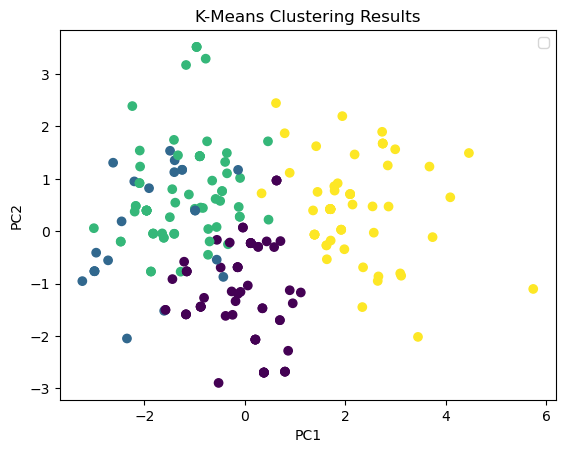

In [30]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Define the features to use for the model
features = ['year','danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo']

# Create a new dataframe with only the features to use for the model
df_model = df_recom[features]

# Scale the features
scaler = StandardScaler()
df_model_scaled = scaler.fit_transform(df_model)

# Fit the K-means model using the new dataframeabs
kmeans = KMeans(n_clusters=4, random_state=42)
kmeans.fit(df_model_scaled)

# Get the cluster labels for each data point
labels = kmeans.labels_
df_recom['clusters'] = labels
# Apply PCA to reduce the dimensionality of the data
pca = PCA(n_components=2)
pca_data = pca.fit_transform(df_model_scaled)

# Plot the data points with different colors based on their cluster labels
plt.scatter(pca_data[:, 0], pca_data[:, 1], c=labels, cmap='viridis')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('K-Means Clustering Results')
plt.legend()
plt.show()

In [31]:
df_recom

,name,artist,popularity,year,iD,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,clusters
0,So Anxious,Ginuwine,0.7,1999,2zbjlcLi1VQWqDNYdhyx1l,0.733,0.633086,0.416228,0.0366,0.27900,0.000002,0.4680,0.661,0.480747,0
1,Weak,SWV,0.7,1992,71EHOyEOhNx1SzTebRRyng,0.693,0.579884,0.561644,0.0402,0.10700,0.000000,0.0695,0.568,0.638733,0
2,Candy Rain,Soul For Real,0.7,1995,4j1Bk0BEIGCF9hR7cSwl9d,0.590,0.398571,0.736565,0.0790,0.00389,0.000047,0.0577,0.630,0.941971,2
3,You Make Me Wanna...,Usher,0.7,1997,47TqCCnEliDp8NRDyIQoQq,0.761,0.401112,0.673340,0.0539,0.03590,0.000000,0.0945,0.922,0.820990,2
4,It Won't Stop (feat. Chris Brown) - EP Version,Sevyn Streeter,0.7,2013,2xRYnHQdLD9ketvC01UYYT,0.657,0.502065,0.604847,0.0407,0.01600,0.000081,0.1720,0.211,0.600362,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
215,Reminiscing - Remastered 2022,Little River Band,0.7,1978,7i3xpu7SFWvzhGa9AZyySR,0.350,0.582848,0.466807,0.0369,0.76200,0.001920,0.0994,0.345,0.946259,3
216,Baker Street,Gerry Rafferty,0.7,1978,5gOd6zDC8vhlYjqbQdJVWP,0.497,0.741133,0.367756,0.0297,0.09290,0.028000,0.2590,0.421,0.569191,3
217,Baby Come Back,Player,0.7,1977,41sGGCCoHI2GLV9qadX80A,0.646,0.541980,0.634352,0.0758,0.05990,0.000017,0.0956,0.543,0.781028,0
218,One More Night - 2016 Remaster,Phil Collins,0.7,1985,6fkvIT9KFKxO8poBeKfaEf,0.534,0.499841,0.465753,0.0308,0.78800,0.000351,0.0986,0.343,0.682302,3


In [32]:
# filter the data to only include cluster 2 values
cluster_0_data = df_recom[df_recom['clusters']==0]
cluster_1_data = df_recom[df_recom['clusters']==1]
cluster_2_data = df_recom[df_recom['clusters'] == 2]
cluster_3_data = df_recom[df_recom['clusters']==3]

In [33]:
cluster_0_data.head()

,name,artist,popularity,year,iD,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,clusters
0,So Anxious,Ginuwine,0.70,1999,2zbjlcLi1VQWqDNYdhyx1l,0.733,0.633086,0.416228,0.0366,0.279,0.000002,0.4680,0.661,0.480747,0
1,Weak,SWV,0.70,1992,71EHOyEOhNx1SzTebRRyng,0.693,0.579884,0.561644,0.0402,0.107,0.000000,0.0695,0.568,0.638733,0
16,Weak,SWV,0.70,1992,71EHOyEOhNx1SzTebRRyng,0.693,0.579884,0.561644,0.0402,0.107,0.000000,0.0695,0.568,0.638733,0
19,I Wanna Be Down,Brandy,0.66,1994,6N9uyMZf9pbNOuomveWscp,0.703,0.344891,0.494204,0.0415,0.177,0.000000,0.7260,0.661,0.430478,0
22,So Anxious,Ginuwine,0.70,1999,2zbjlcLi1VQWqDNYdhyx1l,0.733,0.633086,0.416228,0.0366,0.279,0.000002,0.4680,0.661,0.480747,0


In [34]:
cluster_1_data.head()

,name,artist,popularity,year,iD,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,clusters
10,Back Then,Mike Jones,0.61,2005,5krOROgmf8adn3SJzeKLZy,0.776,0.333933,0.775553,0.255,0.010100,0.0,0.1800,0.536,0.799726,1
11,Po Pimp,Do Or Die,0.56,1996,66AMCAjrOk7c957i3ej06f,0.810,0.754262,0.451001,0.272,0.062300,0.0,0.1160,0.649,0.710851,1
12,Cheese and Dope,Project Pat,0.55,2001,5o0GRUA7okGPALKyEyQabz,0.883,0.269349,0.894626,0.181,0.006970,0.0,0.0877,0.956,0.376202,1
13,Chunk up the Deuce,Lil’ Keke,0.55,1998,7y5A3Ge2GixgSTwCU6fu5p,0.930,0.320963,0.637513,0.322,0.030100,0.0,0.0959,0.857,0.681146,1
14,Pass Me Da Green,Master P,0.54,1997,4U3JMDnjnUKggATEp7NryT,0.646,0.426893,0.482613,0.165,0.000506,0.0,0.1080,0.210,0.730199,1


In [35]:
cluster_2_data.head()

,name,artist,popularity,year,iD,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,clusters
2,Candy Rain,Soul For Real,0.70,1995,4j1Bk0BEIGCF9hR7cSwl9d,0.590,0.398571,0.736565,0.0790,0.00389,0.000047,0.0577,0.630,0.941971,2
3,You Make Me Wanna...,Usher,0.70,1997,47TqCCnEliDp8NRDyIQoQq,0.761,0.401112,0.673340,0.0539,0.03590,0.000000,0.0945,0.922,0.820990,2
4,It Won't Stop (feat. Chris Brown) - EP Version,Sevyn Streeter,0.70,2013,2xRYnHQdLD9ketvC01UYYT,0.657,0.502065,0.604847,0.0407,0.01600,0.000081,0.1720,0.211,0.600362,2
8,Beauty & Essex (feat. Daniel Caesar & Unknown ...,Free Nationals,0.69,2019,0cciBj4236w1xByzZvn92D,0.552,0.286871,0.780822,0.0542,0.28400,0.000082,0.3340,0.718,0.348779,2
9,Baby Powder,Jenevieve,0.69,2021,4Nw7kywWurWS6ceinn1cHK,0.799,0.404500,0.476291,0.0466,0.23800,0.000133,0.0878,0.732,0.392568,2


In [36]:
cluster_3_data.head()

,name,artist,popularity,year,iD,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,clusters
5,DO 4 LOVE,Snoh Aalegra,0.70,2021,3FImu2LpSuH6gDHBuFgIbS,0.367,0.673213,0.149631,0.0319,0.913,0.003670,0.1070,0.1000,0.349369,3
6,Loose,Daniel Caesar,0.70,2017,59acp1OhcvxwVBwQJBYKuX,0.198,0.837215,0.170706,0.0343,0.926,0.008960,0.1350,0.0527,0.352501,3
7,Garden Kisses,Giveon,0.70,2018,62d6YXEYxmMWAuLpw1EysL,0.478,0.503176,0.393045,0.0317,0.915,0.000006,0.1280,0.3540,0.601048,3
31,My Flame,Bobby Caldwell,0.56,1978,1FgyYm1kcXjkdR1VZmaiVo,0.514,0.813446,0.310854,0.0255,0.465,0.000950,0.0728,0.4100,0.436357,3
34,You Don't Have To Change,Kool & The Gang,0.54,1974,3fOTE7xglLPn15SrPj7kxq,0.491,0.852409,0.356164,0.0519,0.571,0.059900,0.2480,0.1670,0.398177,3
